In [1]:
import os
import gym
from keras import backend as K
from keras import optimizers
from _base import build_env, experiment_dir
from _top_level import top_level
top_level()

Using TensorFlow backend.


In [2]:
from src.agents import DeepQAgent
from src.base import AnnealingVariable
from src.models.losses import huber_loss
from src.utils import BaseCallback
from src.utils import JupyterCallback
from src.utils import seed

In [3]:
ENV_ID = 'SuperMarioBrosRandomStages-v0'

In [4]:
# set the random number seed
seed(1)
# make the output directory 
OUTPUT_DIR = experiment_dir('../results', ENV_ID, DeepQAgent.__name__)
OUTPUT_DIR

'../results/SuperMarioBrosRandomStages-v0/DeepQAgent/2019-01-16_20-22'

In [5]:
# create a file to save the weights to
WEIGHTS_FILE = os.path.join(OUTPUT_DIR, 'weights.h5')

In [6]:
# create the environment
env = build_env(ENV_ID)
env.unwrapped.seed(1)
env

<FrameStackEnv<PenalizeDeathEnv<DownsampleEnv<RewardCacheEnv<FrameSkipEnv<BinarySpaceToDiscreteSpaceEnv<TimeLimit<SuperMarioBrosRandomStagesEnv<SuperMarioBrosRandomStages-v0>>>>>>>>>

In [7]:
# create an agent
agent = DeepQAgent(env,
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer='adam',
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=40e6),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=True,
)
agent

DeepQAgent(
    env=<FrameStackEnv<PenalizeDeathEnv<DownsampleEnv<RewardCacheEnv<FrameSkipEnv<BinarySpaceToDiscreteSpaceEnv<TimeLimit<SuperMarioBrosRandomStagesEnv<SuperMarioBrosRandomStages-v0>>>>>>>>>,
    render_mode=None
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=adam,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=40000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=True
)

In [ ]:
# observe random movement in the environment to pre-fill the experience 
# replay queue with memories
agent.observe()

50013frame [04:31, 184.38frame/s]                        


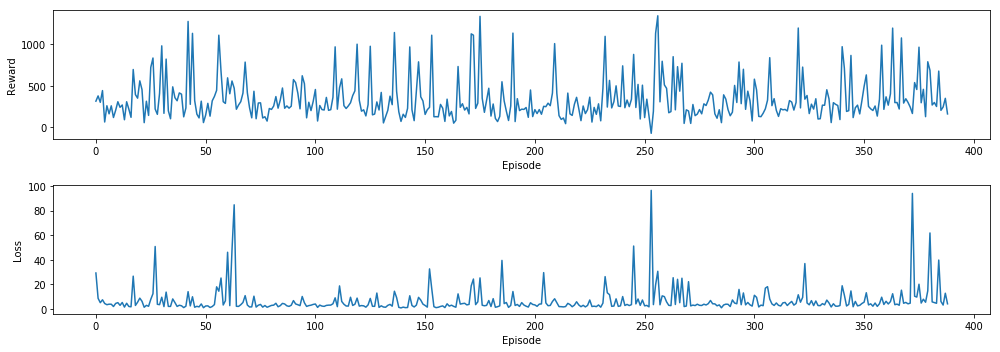

  0%|          | 43631/50000000.0 [07:22<205:05:54, 67.66frame/s, loss=4.12, score=163]

In [ ]:
# create a callback for the training procedure to log metrics
callback = BaseCallback(WEIGHTS_FILE)
plotter = JupyterCallback()
# train the agent with given parameters and the callback
agent.train(50e6, callback=[callback, plotter])
# save the weights to disk after the training procedure
agent.model.save_weights(WEIGHTS_FILE, overwrite=True)

In [ ]:
callback.export(os.path.join(OUTPUT_DIR, 'training'))

In [ ]:
# clear the keras session to remove the training model from memory
K.clear_session()
# create a validation agent with a monitor attatched
agent = DeepQAgent(build_env('SuperMarioBros-v0', monitor_dir=os.path.join(OUTPUT_DIR, 'play')))
# load the trained weights into the validation agent
agent.model.load_weights(WEIGHTS_FILE)

In [ ]:
# run the agent through validation episodes
df = agent.play()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
# plot the validation results and save the tables and figures to disk
agent.plot_episode_rewards(os.path.join(OUTPUT_DIR, 'play'))